In [1]:
from pyspark.sql import SparkSession

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3,application_1604241517055_0004,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
sc.install_pypi_package("pandas")
sc.install_pypi_package("kiwisolver==1.2.0")
sc.install_pypi_package("seaborn")
sc.install_pypi_package("tabulate")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/bf/4c/cb7da76f3a5e077e545f9cf8575b8f488a4e8ad60490838f89c5cdd5bb57/pandas-1.1.4-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/31/b9/6202dcae729998a0ade30e80ac00f616542ef445b088ec970d407dfd41c0/kiwisolver-1.2.0-cp37-cp37m-manylinux1_x86_64.whl

  Using cached https://files.pythonhosted.org/packages/bc/45/5118a05b0d61173e6eb12bc5804f0fbb6f196adb0a20e0b16efc2b8e98be/seaborn-0.11.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/fa/cf/94686c3e2b21cba82904a2bbb014f7529d483021802a0116c3a256b00563/scipy-1.5.3-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/87/a6/8d7d06f6b69236a3c1818157875ceb1259ba0d9df4194f4fe138ffdc0f41/matplotlib-3.3.2-cp37-cp37m-manylinux1_x86_64.whl


In [6]:
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql.types import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from math import sqrt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
from pyspark.mllib.clustering import KMeans,KMeansModel
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import StandardScaler
from pyspark.sql import SQLContext
from pyspark.sql.functions import col, when, to_date, lit, expr, countDistinct, max, min, sum, concat
from pyspark.ml.feature import VectorAssembler

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
sc._jsc.hadoopConfiguration().set("fs.s3.canned.acl","BucketOwnerFullControl")
sqlContext = SQLContext(sc)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
in_bucket = "s3://tfmbigdata/Files_Segunda_Entrega/tickets_*.json"
print("Loading data from {}".format(in_bucket))
tickets = spark.read.format("json").load(in_bucket)
tickets = tickets.drop_duplicates()
tickets = tickets.withColumn("date", to_date("datekey", "yyyy-MM-dd"))
tickets = tickets.groupby(['customerid','storeid','cardtype','date','ticketid','productid']).agg(
    F.sum('extendedamount').alias('extendedamount'),
    F.sum('originalamount').alias('originalamount'),
    F.sum('totaldiscount').alias('totaldiscount'),
    F.sum('quantity').alias('quantity')
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Loading data from s3://tfmbigdata/Files_Segunda_Entrega/tickets_*.json

# Cálculo de RFM

In [10]:
#calculate recency 
max_df = tickets.select(max("date")).collect() 
max_val = max_df[0][0]
tickets = tickets.withColumn('max_date',lit(max_val))
tickets = tickets.withColumn("recencydays", expr("datediff(max_date, date)"))
rfm_table = tickets.groupBy("customerid")\
                    .agg(min("recencydays").alias("recency"), \
                         countDistinct("ticketid").alias("frequency"), \
                         sum("extendedamount").alias("monetary"))



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
rfm_table.summary().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+------------------+------------------+------------------+
|summary|          customerid|           recency|         frequency|          monetary|
+-------+--------------------+------------------+------------------+------------------+
|  count|               49729|             49729|             49729|             49729|
|   mean|7.702318476329838...| 7.859357718836091|18.541917191176175|451.55005208228596|
| stddev|8.570490946602408E13|11.794870672340366|10.192986658841887| 336.6913097668398|
|    min|   77000000050008766|                 0|                 8|              9.22|
|    25%| 7.70000001736116E16|                 1|                11|237.20000000000002|
|    50%| 7.70000002889864E16|                 3|                16|            374.43|
|    75%|7.700000051512784E16|                 9|                23|            579.81|
|    max|   77340000025950510|               106|               312|20508.049999999996|
+-------+--------------------+--

# Eliminación de outliers/Trimming

In [17]:
r_percentile = 0.95
f_percentile = 0.99
m_percentile = 0.99

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
r_trim_cond = f_trim_cond = m_trim_cond = F.lit(True)
r_out_cond = f_out_cond = m_out_cond = F.lit(False)

if r_percentile:
    r_up_boundary = rfm_table.approxQuantile("recency", [r_percentile], 0)
    r_trim_cond = (F.col("recency") < r_up_boundary[0])
    r_out_cond = (F.col("recency") >= r_up_boundary[0])

if f_percentile:
    f_up_boundary = rfm_table.approxQuantile("frequency", [f_percentile], 0)
    f_trim_cond = (F.col("frequency") < f_up_boundary[0])
    f_out_cond = (F.col("frequency") >= f_up_boundary[0])
    
if m_percentile:
    m_up_boundary = rfm_table.approxQuantile("monetary", [m_percentile], 0)
    m_trim_cond = (F.col("monetary") < m_up_boundary[0])
    m_out_cond = (F.col("monetary") >= m_up_boundary[0])



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
rfm_boundaries = {
    'r': r_up_boundary,
    'f': f_up_boundary,
    'm': m_up_boundary,
}

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
rfm_trimmed = rfm_table
rfm_trimmed = rfm_trimmed.filter(r_trim_cond & f_trim_cond & m_trim_cond)
rfm_outliers = rfm_table
rfm_outliers = rfm_outliers.filter(r_out_cond | f_out_cond | m_out_cond)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
rfm_trimmed.summary().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+-----------------+-----------------+------------------+
|summary|          customerid|          recency|        frequency|          monetary|
+-------+--------------------+-----------------+-----------------+------------------+
|  count|               46277|            46277|            46277|             46277|
|   mean|7.702286436363896E16|5.755753398016293|18.21243814421851| 439.7164701687666|
| stddev| 8.51537310509231E13|6.567814626453112|8.642897823414524|267.17695109237826|
|    min|   77000000050008766|                0|                8|              9.22|
|    25%|7.700000017381568E16|                1|               12|            240.41|
|    50%|7.700000028953678...|                3|               16|376.77000000000004|
|    75%|7.700000051668411...|                7|               23| 576.3199999999999|
|    max|   77340000025950510|               32|               51|1505.3000000000002|
+-------+--------------------+-----------------+------

In [15]:
total_count = rfm_table.count()
trimmed_count = rfm_trimmed.count()
outliers_count = rfm_outliers.count()
print(f"Total = {total_count}")
print(f"Trimmed = {trimmed_count}")
print(f"Outliers = {outliers_count}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total = 49729
Trimmed = 46687
Outliers = 3042

In [22]:
rfm_trimmed = rfm_table
rfm_trimmed = rfm_trimmed.filter((col("recency") < r_up_boundary[0]) & (col("frequency") < f_up_boundary[0]) & (col("monetary") < m_up_boundary[0]))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
rfm_outliers = rfm_table
rfm_outliers = rfm_outliers.filter((col("recency") >= r_up_boundary[0]) | (col("frequency") >= f_up_boundary[0]) | (col("monetary") >= m_up_boundary[0]))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
total_count = rfm_table.count()
trimmed_count = rfm_trimmed.count()
outliers_count = rfm_outliers.count()
print(f"Total = {total_count}")
print(f"Trimmed = {trimmed_count}")
print(f"Outliers = {outliers_count}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total = 49729
Trimmed = 46277
Outliers = 3452

In [25]:
#create quartiles for each metric
r_quartile = rfm_trimmed.approxQuantile("recency", [0.25, 0.5, 0.75], 0)
f_quartile = rfm_trimmed.approxQuantile("frequency", [0.25, 0.5, 0.75], 0)
m_quartile = rfm_trimmed.approxQuantile("monetary", [0.25, 0.5, 0.75], 0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
r_quartile

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[1.0, 3.0, 7.0]

In [27]:
spark.createDataFrame(r_quartile, FloatType()).write.mode('overwrite').csv("s3a://mbde-tfm-grupo3/quartiles/r_quartile")
spark.createDataFrame(f_quartile, FloatType()).write.mode('overwrite').csv("s3a://mbde-tfm-grupo3/quartiles/f_quartile")
spark.createDataFrame(m_quartile, FloatType()).write.mode('overwrite').csv("s3a://mbde-tfm-grupo3/quartiles/m_quartile")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
r_quartile_load = sorted([row[0] for row in spark.read.csv("s3a://mbde-tfm-grupo3/quartiles/r_quartile").collect()])
f_quartile_load = sorted([row[0] for row in spark.read.csv("s3a://mbde-tfm-grupo3/quartiles/f_quartile").collect()])
m_quartile_load = sorted([row[0] for row in spark.read.csv("s3a://mbde-tfm-grupo3/quartiles/m_quartile").collect()])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
r_quartile = r_quartile_load
f_quartile = f_quartile_load
m_quartile = m_quartile_load

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:

#assing score from 1 to 4 dependending on quantile => 1 best mark - 4 worst one
rfm_table = rfm_table.withColumn("r_quartile",when(col("recency") > r_quartile[2] , 4).\
                                                        when(col("recency") > r_quartile[1] , 3).\
                                                        when(col("recency") > r_quartile[0] , 2).\
                                                        otherwise(1))                               

rfm_table = rfm_table.withColumn("f_quartile",when(col("frequency") > f_quartile[2] , 1).\
                                                        when(col("frequency") > f_quartile[1] , 2).\
                                                        when(col("frequency") > f_quartile[0] , 3).\
                                                        otherwise(4))                               

rfm_table = rfm_table.withColumn("m_quartile",when(col("monetary") > m_quartile[2] , 1).\
                                                        when(col("monetary") > m_quartile[1] , 2).\
                                                        when(col("monetary") > m_quartile[0] , 3).\
                                                        otherwise(4))

rfm_table = rfm_table.withColumn("rfm_score", concat(col("r_quartile"), col("f_quartile"), col("m_quartile")))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
assembler = VectorAssembler(inputCols=['r_quartile','f_quartile','m_quartile'],\
                            outputCol='features',handleInvalid = 'skip')
rfm_table = assembler.transform(rfm_table)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
standardizer = StandardScaler(withMean=True, withStd=True).setInputCol("features").setOutputCol("scaled_features")
std_model = standardizer.fit(rfm_table)
features = std_model.transform(rfm_table)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
train_features = features.select('scaled_features').rdd.map(lambda x: x[0].toArray()).cache()

def extract(row):
    return tuple(row.scaled_features.toArray().tolist())
rm_features = features.select('scaled_features').rdd.map(extract).toDF()
rows_count = rm_features.count()

In [65]:
WSSSE={}

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Calculo de centroides

In [132]:
N_CLUSTERS=10

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [133]:
chunk_size=np.ceil(rows_count/N_CLUSTERS)
bc_chunk_size = sc.broadcast(chunk_size)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [134]:
r_vector = rm_features.select('_1').rdd.sortBy(lambda x: x[0]).zipWithIndex().map(lambda x: (x[0][0],int(x[1]/bc_chunk_size.value))).toDF()
f_vector = rm_features.select('_2').rdd.sortBy(lambda x: x[0]).zipWithIndex().map(lambda x: (x[0][0],int(x[1]/bc_chunk_size.value))).toDF()
m_vector = rm_features.select('_3').rdd.sortBy(lambda x: x[0]).zipWithIndex().map(lambda x: (x[0][0],int(x[1]/bc_chunk_size.value))).toDF()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [135]:
r_median = r_vector.groupby('_2').agg(F.expr('percentile_approx(_1, 0.5)').alias('r_median'))
f_median = f_vector.groupby('_2').agg(F.expr('percentile_approx(_1, 0.5)').alias('f_median'))
m_median = m_vector.groupby('_2').agg(F.expr('percentile_approx(_1, 0.5)').alias('m_median'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [136]:
rfm_medians = r_median.join(f_median,'_2').join(m_median,'_2').sort('_2').select(['r_median','f_median','m_median'])
initial_centroids = rfm_medians.rdd.map(lambda x: np.array([x[0],x[1],x[2]])).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [137]:
initial_centroids

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[array([-1.27544294, -1.41052596, -1.33811803]), array([-1.27544294, -1.41052596, -1.33811803]), array([-1.27544294, -0.54401521, -1.33811803]), array([-0.42239731, -0.54401521, -0.45062591]), array([-0.42239731, -0.54401521, -0.45062591]), array([0.43064833, 0.32249555, 0.43686621]), array([0.43064833, 0.32249555, 0.43686621]), array([1.28369396, 1.1890063 , 1.32435832]), array([1.28369396, 1.1890063 , 1.32435832]), array([1.28369396, 1.1890063 , 1.32435832])]

In [138]:
initial_model = KMeansModel(initial_centroids)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## K-Means train

In [139]:
kmeans = KMeans.train(train_features, N_CLUSTERS ,initialModel=initial_model)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [140]:
labels = features.select(['customerid','scaled_features']).rdd.map(lambda x: (x[0], kmeans.predict(x[1].toArray()))).toDF(['customerid','prediction'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [141]:
# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = kmeans.centers[kmeans.predict(point)]
    return sqrt(np.sum([x**2 for x in (point - center)]))

WSSSE[N_CLUSTERS] = train_features.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error ["+str(N_CLUSTERS)+"] = " + str(WSSSE[N_CLUSTERS]))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Within Set Sum of Squared Error [10] = 34612.608789424936

In [145]:
WSSSE

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{6: 42462.15084023132, 3: 55156.445139052, 4: 48729.03759243115, 5: 46013.76649606643, 7: 39145.84232702882, 8: 36668.69804034483, 9: 35363.837954988565, 10: 34612.608789424936}

In [58]:
prediction = features.join(labels,'customerid')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [59]:
prediction_map = {
    'best': 0,
    'promising': 1,
    'loyal': 2,
    'new': 3,
    'risk': 4,
    'lost' :5
}

prediction_map = dict((v,k) for k,v in prediction_map.items())
map_func = F.udf(lambda row : prediction_map.get(row,row))
prediction = prediction.withColumn("segmento",map_func(col('prediction')))
prediction = prediction.withColumn("prediction_label",F.concat(F.lit('('),col('prediction'),F.lit(') '),col('segmento')))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [86]:
prediction

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[customerid: string, recency: int, frequency: bigint, monetary: double, r_quartile: int, f_quartile: int, m_quartile: int, rfm_score: string, features: vector, scaled_features: vector, prediction: bigint, segmento: string, prediction_label: string]

In [60]:
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

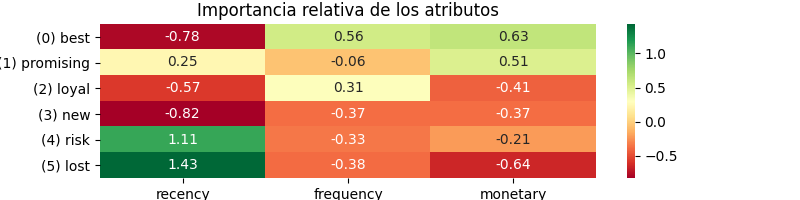

In [61]:
plt.clf()
population_avg = prediction.select(
                        _mean(col('recency')).alias('recency'),
                        _mean(col('frequency')).alias('frequency'),
                        _mean(col('monetary')).alias('monetary'),
                    ).toPandas()
cluster_avg = prediction.groupby(['prediction_label']).mean().select(col('prediction_label'),\
                                                 col('avg(recency)').alias('recency'),\
                                                 col('avg(frequency)').alias('frequency'),\
                                                 col('avg(monetary)').alias('monetary')).toPandas()


relative_imp = cluster_avg.groupby(['prediction_label']).mean() / population_avg.mean() - 1

# # km_clusters_mean = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Amount.mean())
# # km_clusters_frequency = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Frequency.mean())
# # km_clusters_recency = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Recency.mean())
plt.figure(figsize=(8, 2))
plt.title('Importancia relativa de los atributos')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()
%matplot plt

In [62]:
# Gasto relativo
total_rows = prediction.count()
total_monetary = prediction.select('monetary').rdd.map(lambda x: (1,x[0])).reduceByKey(lambda x,y: x + y).collect()[0][1]


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [115]:
12123/total_rows*100

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

24.37812946168232

In [107]:
print(prediction.groupby(['prediction_label']).count().toPandas())
print(prediction.groupby('prediction_label').agg(F.sum('monetary')/total_monetary).toPandas())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  prediction_label  count
0         (5) lost   6689
1        (2) loyal   6283
2          (1) new   8035
3         (4) risk   7817
4         (0) best  12123
5    (3) promising   8782
  prediction_label  (sum(monetary) / 2.2455132539999995E7)
0         (5) lost                                0.048535
1        (2) loyal                                0.074466
2          (1) new                                0.243816
3         (4) risk                                0.124073
4         (0) best                                0.398028
5    (3) promising                                0.111082

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

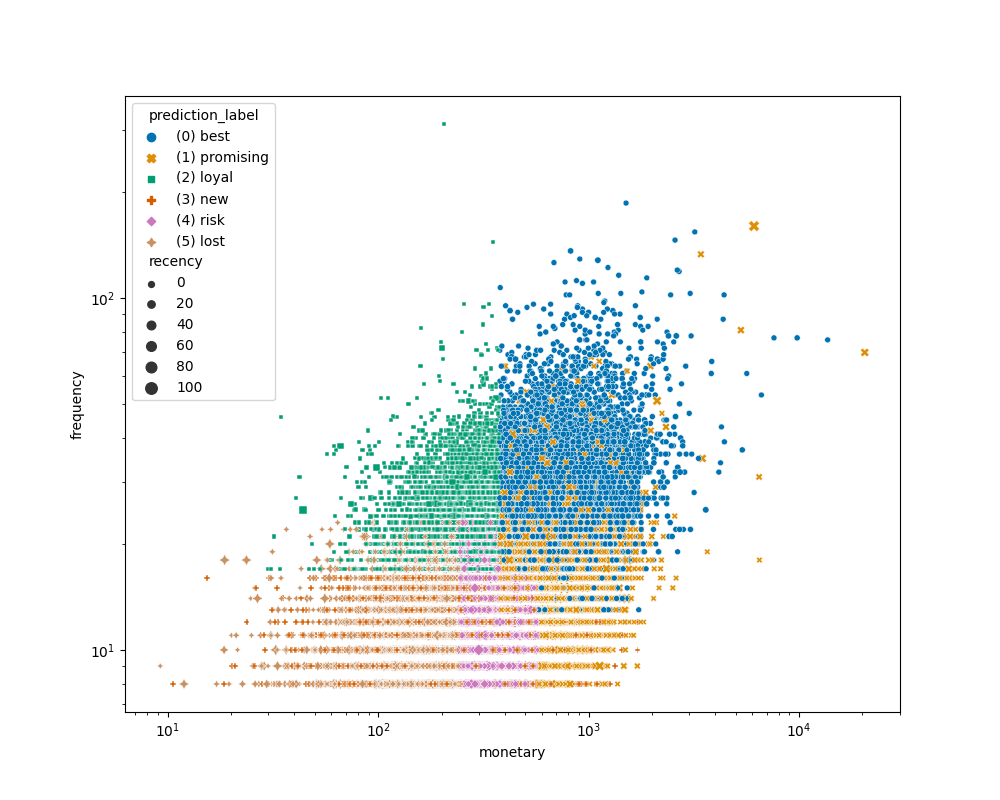

In [63]:
plt.clf()
rfm_clus = prediction.select(  
                        col('prediction_label'),\
                        col('recency'),\
                        col('frequency'),\
                        col('monetary')
                    ).toPandas()
rfm_clus['prediction'] = rfm_clus['prediction_label'].astype("category")
plt.figure(figsize=(10,8))
with sns.color_palette("colorblind"):
  ax = sns.scatterplot(x="monetary", y="frequency",
                     hue="prediction_label", 
                    #  hue_norm=(0,255),
                    size="recency",
                    #palette=sns.colorblind_palette(as_cmap=True), 
                    #  sizes=(10, 200),
                     data=rfm_clus,
                      style="prediction_label")
ax.set_xscale('log')
ax.set_yscale('log')

%matplot plt

In [91]:
prediction.write.mode('overwrite').format('json').save('s3://mbde-tfm-grupo3/prediction')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…